MCT Blog Sonified

In [3]:
import os
import re
import numpy as np
import pandas as pd
import markdown
import string
import matplotlib.pyplot as plt
import librosa
import IPython.display as ipd
import scipy
import soundfile as sf
from collections import Counter
from bs4 import BeautifulSoup

In [4]:
def md_to_text(md):
    # function cleans markdown
    html = markdown.markdown(md)
    soup = BeautifulSoup(html, features='html.parser')
    return soup.get_text()

def clean_text(text):
    text = text.lower()
    text = re.sub("(\[.*\])", "", text)
    text = re.sub("(http[s]?\://\S+)", "", text)
    text = re.sub("[0-9]", "", text)
    text = re.sub("\S*@\S*\s?", "", text)
    text = re.sub("/\S+/\S+", "", text)
    text = re.sub("\n", " ", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub("\s+", " ", text)
    return text

In [5]:
path = './posts'
files = os.listdir(path)

# iterate files, get text, remove frontmatter
all = ''
for i, file in enumerate([s for s in files if s.endswith('.md')]):
    text = ''
    with open(os.path.join(path, file), encoding = 'utf-8') as f:
        md = f.read()
        md = re.sub("\n", " ", md)
        md = re.sub(r"---.*---", '', md) # frontmatter
        text = md_to_text(md)
        all += text

# clean text
cleaned = clean_text(all)

# write all to txt
with open('all_words.txt', 'w', encoding='utf-8') as f:
    f.write(cleaned)

0 2018-08-22-introduction-group-b.md
1 2018-08-22-introduction-group-c.md
2 2018-08-23-introduction-group-a.md
3 2018-08-23-introduction-group-d.md
4 2018-09-07-opening-ceremony-stillness-under-tension.md
5 2018-09-10-A-team-first-week.md
6 2018-09-17-Group-B-setting-up-tico.md
7 2018-10-03-A-team-presentation.md
8 2018-10-16-A-Team-Recording and sampling.md
9 2018-10-17-C-First-Day-What-Ever-Comes-Along.md
10 2018-10-17-Group-B-Cicruit-sniffing-and-sampling.md
11 2018-10-17-Group-B-Physical-computing-day-2.md
12 2018-10-17-Group-C-Developing-Mobile-Musical-Instruments.md
13 2018-10-18-A-team-Arduino and littleBits.md
14 2018-10-18-A-team-Phone sensors, synths and samples.md
15 2018-10-18-Group-B-christmas-already.md
16 2018-10-18-Group-C-Think-Outside-The-Box.md
17 2018-10-21-Group-D-Jamming-in-the-Portal.md
18 2018-10-22-A-team-Workshop finale.md
19 2018-10-22-Group-B-Making-the-Percampler.md
20 2018-10-22-Group-C-The-Koolboard.md
21 2018-10-29-Group-C-A-two-week-wrap-up.md
22 2018-1

In [6]:
len(all)

2233883

In [7]:
words = cleaned.split(' ')
counts = Counter(words)
commons = counts.most_common()

df_freq = pd.DataFrame(commons, columns=['words','freq'])

df_freq

,words,freq
0,the,19044
1,to,8371
2,and,8002
3,of,6977
4,a,6657
...,...,...
15040,nontechnical,1
15041,disk,1
15042,clientserver,1
15043,kilometres,1


In [8]:
df_words = pd.DataFrame(words, columns = ['words'])

df = df_words.merge(df_freq, how='left')

# unwanted words
unwanted_words = ['', 'the', 'to', 'and', 'of', 'a', 'in', 'is', 'for', 'with', 'that']
df = df[~df['words'].isin(unwanted_words)]

# filter less freq (<10)
df = df[df['freq']>10]


# scale frequency
df['freq'] = df['freq']*2.5

# create 
df['w_len'] = df['words'].str.len()

df

,words,freq,w_len
1,team,345.0,4
2,name,97.5,4
3,made,630.0,4
4,we,6642.5,2
5,are,3182.5,3
...,...,...,...
265731,comfortable,40.0,11
265733,running,190.0,7
265736,links,40.0,5
265739,jacktrip,175.0,8


In [9]:
df.sort_values(by='freq', ascending=False).head()#to_csv('most_common_sorted_words.csv')

,words,freq,w_len
73879,we,6642.5,2
55028,we,6642.5,2
17300,we,6642.5,2
55139,we,6642.5,2
6262,we,6642.5,2


In [10]:
# create averaged dataframe
df_avg = pd.DataFrame()
roll = 25
step = 25
df_avg['f_mean'] = df['freq'].rolling(roll, step=step).mean().dropna().reset_index(drop=True)
df_avg['w_len'] = df['w_len'].rolling(roll, step=step).mean().dropna().reset_index(drop=True)

df_avg #, df_diff

,f_mean,w_len
0,1108.7,6.36
1,1041.2,6.08
2,1148.9,6.16
3,1035.7,6.08
4,420.9,5.40
...,...,...
6774,1525.5,5.12
6775,1114.9,5.76
6776,1213.2,4.72
6777,1030.6,5.84


In [11]:
df_avg.describe()

,f_mean,w_len
count,6779.000000,6779.000000
mean,1174.071840,5.271999
std,349.727644,0.684012
min,177.500000,2.800000
25%,927.600000,4.800000
50%,1156.400000,5.240000
75%,1404.550000,5.720000
max,2493.400000,8.200000


In [12]:
# sonify

sr = 48000
sr_ms = int(sr/1000)
signal = np.array([])
for i, row in df_avg.iterrows():
    # for every event create audio signal and append it to the main signal
    freq = row['f_mean']
    note_dur = int(row['w_len']**2.5*1.5+10) #ms
    start_sample = i*note_dur*sr_ms
    dur_sample = note_dur*sr_ms

    # sin wave
    f = freq
    A = 1 #vel/max_vel
    t = np.arange(0,note_dur/1000,1/sr)
    s = A*np.sin(2*np.pi*f*t)

    # window
    window = scipy.signal.windows.general_hamming(len(s), alpha=0.5)

    # append
    signal = np.concatenate((signal, s*window))

for i in df_avg.index:
    start_sample = i*note_dur*sr_ms
    dur_sample = note_dur*sr_ms

signal

array([ 0.00000000e+00,  2.33168085e-08,  1.84573464e-07, ...,
       -1.21225211e-07, -5.79717102e-08, -0.00000000e+00])

In [13]:
# export

sf.write('mct_blog_sonified_testing_01.wav', signal, sr)

# notes below

In [79]:
# equal note durations (not used)
sr = 48000
sr_ms = int(sr/1000)
note_dur = 100 #ms
dat = avg
signal = np.zeros(len(dat)*note_dur*sr_ms)
for i, v in enumerate(dat):
    # for every event create audio signal and embed it into the main signal
    freq = v
    start_sample = i*note_dur*sr_ms
    dur_sample = note_dur*sr_ms

    # sin wave
    f = freq
    A = 1 #vel/max_vel
    t = np.arange(0,note_dur/1000,1/sr)
    s = A*np.sin(2*np.pi*f*t)

    # place it into its position in the main signal by addition
    signal[start_sample : start_sample + dur_sample] += s
    anan = signal[0 : start_sample + dur_sample]
    
signal

array([ 0.        ,  0.03533556,  0.07062699, ..., -0.10192446,
       -0.06801529, -0.03402735])

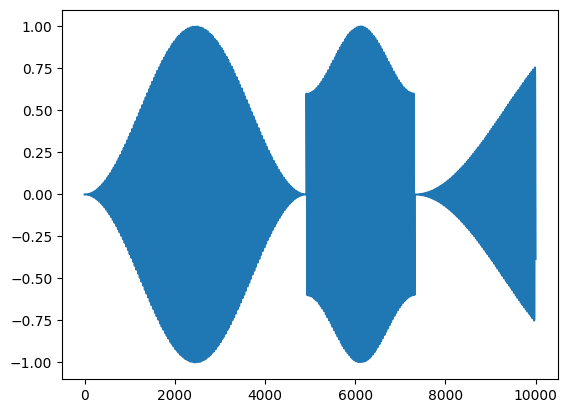

In [209]:
# chirp (not used)
# chirp
chirp = np.array([])
if i != 0:
    interval_length = 50/1000 # in seconds
    fs = sr # sampling of your signal
    f0 = df_avg['f_mean'].iloc[i-1] # frequency 1
    f1 = freq  # frequency 2
    t = np.linspace(0, interval_length, int(fs * interval_length))
    chirp = scipy.signal.chirp(t, f0=f0, f1=f1, t1=interval_length, method='linear')

# chirp window
window_chirp = scipy.signal.windows.general_hamming(len(chirp), alpha=0.8)

signal[start_sample-:start_sample+25] += chirp*window_chirp

# derivative (not used)
df_diff = df.copy()
df_diff['freq'] = df['freq'].diff()